# Demo:  Document Clustering and Latent Semantic Analysis

An important application of clustering is for sorting documents into groups.  In this demo, we will illustrate how to use the k-means algorithms for this task.  This example is taken mostly from one of the [sklearn examples](http://scikit-learn.org/stable/auto_examples/text/document_clustering.html).

Through the demo, you will learn how to:
* Represent a corpus as a set of strings
* Build a vocabulary from a corpus
* Compute the TF-IDF scores for the documents in the corpus based on the vocabulary
* Run k-means to automatically discover document clusters
* Display key terms in each document cluster
* Perform an LSA on a corpus with a sparse SVD.

## Loading the Data

First, we load the standard packages along with a number of `sklearn` sub-packages for text processing.

In [38]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import sys
from time import time

import numpy as np

The [UseNet newsgroups](https://en.wikipedia.org/wiki/Usenet_newsgroup) were popular 20 years ago as online forums for discussing various issues.  Although they are not used much today for topic discussions, the posts from that era are still widely-used in machine learning classes for demonstrating various text processing methods.  Due to their wide use, the `sklearn` package has a built-in routine `fetch_20newsgroups` for extracting the newsgroup examples.  We will extract just four of the 20 categories in this demo.

In [39]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]
# Uncomment the following to do the analysis on all the categories
categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

Loading 20 newsgroups dataset for categories:
None


We use the `np.unique` command to compute the number of unique labels.

In [40]:
labels = dataset.target
true_k = len(np.unique(labels))

In [42]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

The data is in the `data` field of `dataset`.  Each entry `dataset.data[i]` is a string corresponding to the post to the newsgroup.  We can print an example as follows.

In [43]:
doc_ind = 10  # Index of an example document
data_ex = dataset.data[doc_ind]
cat_ex  = dataset.target_names[labels[doc_ind]]
print('Post from {0:s}'.format(cat_ex))
print()
print(data_ex)

Post from talk.religion.misc

From: sandvik@newton.apple.com (Kent Sandvik)
Subject: Re: 14 Apr 93   God's Promise in 1 John 1: 7
Organization: Cookamunga Tourist Bureau
Lines: 17

In article <1qknu0INNbhv@shelley.u.washington.edu>, > Christian:  washed in
the blood of the lamb.
> Mithraist:  washed in the blood of the bull.
> 
> If anyone in .netland is in the process of devising a new religion,
> do not use the lamb or the bull, because they have already been
> reserved.  Please choose another animal, preferably one not
> on the Endangered Species List.  

This will be a hard task, because most cultures used most animals
for blood sacrifices. It has to be something related to our current
post-modernism state. Hmm, what about used computers?

Cheers,
Kent
---
sandvik@newton.apple.com. ALink: KSAND -- Private activities on the net.



## Computing TF-IDF features

Documents are natively text.  To apply most machine learning algorithms, we need to convert the documents to vectors.  One popular method is the so-called TF-IDF score.  First, we select a set of words in the corpus.  Each word is sometimes called a *token*.  For each token `n` and document `i`, we then compute the data matrix:
      
    X[n,i] = TF-IDF score of word i in document n
           = term freq[n,i] * inverse doc frequency[i]
           
where

    term freq[n,i]  = (#occurances of word i in doc n)/(#words in doc n)  
    inverse doc freq[i] = log(#docs in corpus/#docs with word i)
        
In the data matrix `X`, each document `n` is represented by a vector `X[n,:]`.

The data matrix `X` can be computed by a *vectorizer*.  Writing an efficient vectorizer is somewhat time-consuming.  Luckily, `sklearn` has very good routines to compute the TF-IDF representations of a corpus.  We first create a `TfidfVectorizer` object:

In [44]:
vectorizer = TfidfVectorizer( 
                max_df=0.5, # max doc freq (as a fraction) of any word to include in the vocabulary
                min_df=2,   # min doc freq (as doc counts) of any word to include in the vocabulary
                max_features=10000,           # max number of words in the vocabulary
                stop_words='english',         # remove English stopwords
                use_idf=True )        # use IDF scores

Then, we create the data matrix from the dataset.

In [45]:
print("Extracting features from the training dataset using a sparse vectorizer")
t0 = time()
X = vectorizer.fit_transform(dataset.data)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)

Extracting features from the training dataset using a sparse vectorizer
done in 3.857429s
n_samples: 18846, n_features: 10000


We can display the terms with the highest TF-IDF scores in a post as follows.

In [46]:
doc_ind = 10  # Index of an example document
xi = X[doc_ind,:].todense()
term_ind = xi.argsort()[:, ::-1]
xi_sort = xi[0,term_ind]
terms = vectorizer.get_feature_names()

for i in range(30):
    term = terms[term_ind[0,i]]
    tfidf = xi[0,term_ind[0,i]]
    print('{0:20s} {1:f} '.format(term, tfidf))

sandvik              0.357121 
blood                0.305580 
washed               0.289230 
lamb                 0.288139 
bull                 0.250997 
newton               0.229809 
kent                 0.220920 
apple                0.174029 
cultures             0.145176 
reserved             0.132243 
cookamunga           0.131948 
tourist              0.129996 
species              0.128711 
ksand                0.128463 
shelley              0.126812 
alink                0.125927 
preferably           0.124873 
animal               0.120635 
task                 0.119349 
promise              0.119194 
bureau               0.118289 
used                 0.118105 
hmm                  0.117423 
animals              0.117282 
cheers               0.106095 
computers            0.104557 
activities           0.103128 
choose               0.099087 
related              0.092940 
process              0.091737 


## Run k-Means

We now run k-means on the TF-IDF vectors to try  to automatically detect clusters.  First, we construct a `kMeans` object to perform the clustering.

In [48]:
n_clusters = 4
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=True)

Then, we run the k-means clustering.  This will run through several iterations.

In [49]:
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(max_iter=100, n_clusters=4, n_init=1, verbose=True)
Initialization complete
Iteration 0, inertia 36337.09243792916
Iteration 1, inertia 18479.88327420127
Iteration 2, inertia 18434.914541124974
Iteration 3, inertia 18425.759994364245
Iteration 4, inertia 18420.407132933215
Iteration 5, inertia 18418.026855872584
Iteration 6, inertia 18416.707559600905
Iteration 7, inertia 18415.399771443666
Iteration 8, inertia 18414.262330912366
Iteration 9, inertia 18413.42934995134
Iteration 10, inertia 18412.73996702189
Iteration 11, inertia 18412.13099623699
Iteration 12, inertia 18411.737378501977
Iteration 13, inertia 18411.53192550196
Iteration 14, inertia 18411.42049844209
Iteration 15, inertia 18411.341118365905
Iteration 16, inertia 18411.288845808955
Iteration 17, inertia 18411.257280825997
Iteration 18, inertia 18411.228933767565
Iteration 19, inertia 18411.21188119208
Iteration 20, inertia 18411.20006707883
Iteration 21, inertia 18411.19167540861
Iterati

To get an idea of the clusters, we print out the terms corresponding to the 10 largest components of the centroid in each cluster.  You can clearly see the clustering of topics.

In [51]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: game team games hockey ca year players baseball toronto season
Cluster 1: university windows posting host nntp thanks know ca like use
Cluster 2: god people don think jesus com just say article israel
Cluster 3: com article netcom posting hp nntp host key clipper don


In [53]:
cluster = km.transform(X)
cluster[:10]

array([[0.97761504, 0.99746142, 1.0041862 , 1.00163367],
       [1.00862735, 0.98928932, 1.00622366, 1.00078849],
       [1.00246014, 0.99381783, 0.98013455, 0.99630465],
       [1.00821963, 0.98604571, 1.00580171, 0.99243585],
       [1.00144428, 0.9824318 , 1.00108594, 0.99531868],
       [1.00031866, 0.98838794, 0.9984996 , 0.98584234],
       [1.00700424, 0.9946153 , 1.00663622, 0.99939996],
       [0.97470003, 0.99488986, 1.00304433, 0.99984207],
       [0.98601417, 0.99369738, 1.00115704, 0.99817066],
       [1.00758474, 1.00103054, 0.9932828 , 1.00591193]])

## Comparison of clusters to newsgroup categories

The clusters found by k-means were not based on the newsgroup category in which the post came from.  To compare the two, we create a sort of confusion matrix where:

`C[i,j] = ` fraction of cluster `j` came from newsgroup `i`.

In [11]:
labelkm = km.labels_
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels,labelkm)

Csum = np.sum(C,axis=0)
Cnorm = C / Csum[None,:]
print(Cnorm)

[[0.0015873  0.07790627 0.55480984 0.79090909]
 [0.01269841 0.58673159 0.00111857 0.        ]
 [0.97936508 0.22337188 0.0033557  0.        ]
 [0.00634921 0.11199026 0.44071588 0.20909091]]


To interpret this confusion matrix, let's print out the newsgroup names:

In [12]:
dataset.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

Now, returning to the confusion matrix, we see that some discovered clusters lie almost entirely within one of the newsgroup subjects.  This is especially true for `comp.graphics` and `sci.space`.  However, some discovered clusters tend to have entries of both `alt.atheism` and `talk.religon.misc`, whose topics are likely to have a lot of overlap.

We print an example of a post that came from a newsgroup that is different from the most common newsgroup in that cluster.

In [13]:
I = np.where((labels==3) & (labelkm == 3))[0]
doc_ind = I[3]
ind_cluster = labelkm[doc_ind]
km_cat = dataset.target_names[np.argmax(Cnorm[:,ind_cluster])]

data_ex = dataset.data[doc_ind]
true_cat  = dataset.target_names[labels[doc_ind]]
print('Actual newsgroup: {0:s}'.format(true_cat))
print('Most common newsgroup in cluster:  {0:s}'.format(km_cat))
print()
print(data_ex)

Actual newsgroup: talk.religion.misc
Most common newsgroup in cluster:  alt.atheism

From: nrp@st-andrews.ac.uk (Norman R. Paterson)
Subject: Re: After 2000 years, can we say that Christian Morality is
Organization: St. Andrews University, Scotland.
Lines: 16

In article <1r59na$e81@fido.asd.sgi.com> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
>In article <1993Apr21.141259.12012@st-andrews.ac.uk>, nrp@st-andrews.ac.uk (Norman R. Paterson) writes:
>|> In article <1r2m21$8mo@fido.asd.sgi.com> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
...
>> Ok, so you don't claim to have an absolute moral system.  Do you claim
>> to have an objective one?  I'll assume your answer is "yes," apologies
>> if not.
>
>I've just spent two solid months arguing that no such thing as an
>objective moral system exists.
>
>jon.

Apologies, I've not been paying attention.

-Norman



## Latent Semantic Analysis

Another important tool in document analysis is [latent semantic analysis (LSA)](https://en.wikipedia.org/wiki/Latent_semantic_analysis).  In LSA, we simply compute an SVD of the TF-IDF matrix,

    X = U diag(S) V
    
This is equivalent to performing a PCA on `X`.  If we let `A = U diag(S)` then `X = AV`.  First, we compute the PCs of `X`.  Since `X` is a sparse matrix, it is preferable to use the sparse `svds` method in the `scipy` package.

In [14]:
import scipy.sparse.linalg
U1,S1,V1 = scipy.sparse.linalg.svds(X,k=300)

We can next plot the singular values. We see that the first few singular values are significantly larger than the remaining singular values suggesting that the term-document matrix `X` has a low rank structure.

In [16]:
import matplotlib.pyplot as plt

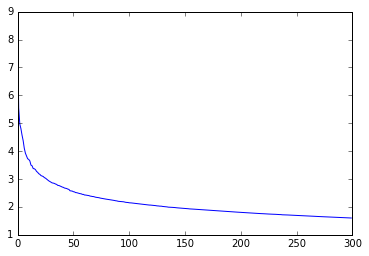

In [38]:
plt.plot(S1[::-1])

Given the low rank structure of `X`, we can write 

     X[n,i] = \sum_k A[n,k] V[k,i]
     
where the sum is over some relatively small number of components.  There are two uses for this representation:
* Word and document embeddings:  A[n,:] provides a low-dimensional vector representation of each document.  This is useful pre-processing step in many natural processing (NLP) methods.  This type of representation is closely related to an important topic of *word embeddings* and *document embeddings*.
* Topic modeling:  One interpretation of the PCA is that each PC `k` represents some common *topic* in the corpus.  Then, `A[n,k] =` the component of topic `k` in document `n` and `V[k,i]` represents the occurance of word `i` in topic `k`.

To get an idea of the words within each PC, we print the words for the largest components in the first 5 PCs.  On a small corpus like 20 newsgroups, the PCs in this case are not very useful.  But, the technique can yield more useful results in larger corpi.

In [41]:
V1sort = np.abs(V1).argsort()[:, ::-1]
for i in range(5):
    print("PC %d:" % i, end='')
    for ind in V1sort[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

PC 0: muenchen does dan bockamp targa colour shall ch uk man
PC 1: phigs government uci 3d khomeini colorado uni rh rayshade screen
PC 2: clarke asimov wesleyan values vga physics fl ed pluto tyre
PC 3: ericsson color wesleyan point program convenient boeing scott targa jpeg
PC 4: thanks muenchen format mac earth pluto color uci true ether


In [17]:
U1.shape

(3387, 300)

In [34]:
from sklearn.decomposition import TruncatedSVD
pca = TruncatedSVD(n_components=5)
X_tr = pca.fit_transform(X)

In [35]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1,
                verbose=True)
km.fit(X_tr)

Initialization complete
Iteration 0, inertia 86.27353297947184
Iteration 1, inertia 53.17605492696268
Iteration 2, inertia 52.017132158220114
Iteration 3, inertia 51.32589878421361
Iteration 4, inertia 50.99974695298535
Iteration 5, inertia 50.85708605986888
Iteration 6, inertia 50.80220190835376
Iteration 7, inertia 50.758690599261435
Iteration 8, inertia 50.73585498021275
Iteration 9, inertia 50.71972442121352
Iteration 10, inertia 50.713337634106075
Iteration 11, inertia 50.71068661044915
Iteration 12, inertia 50.706919021802136
Iteration 13, inertia 50.70432669115986
Converged at iteration 13: center shift 2.474934615666404e-07 within tolerance 6.349559876836782e-07


KMeans(max_iter=100, n_clusters=4, n_init=1, verbose=True)

In [36]:
V_tr =  km.cluster_centers_
V_tr.shape
V = pca.inverse_transform(V_tr)

order_centroids = np.fliplr(np.argsort(V, axis=1))

In [37]:
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: henry space toronto access digex nasa zoo pat spencer alaska
Cluster 1: god com don people space graphics university know just like
Cluster 2: sandvik kent apple newton com alink ksand jesus net cookamunga
Cluster 3: sgi livesey keith wpd solntze jon caltech com morality moral
